# Comprendre l'énoncé du problème de notre projet Speech-to-Text

Comprenons l'énoncé du problème de notre projet avant de passer à la partie mise en œuvre.

Nous sommes peut-être sur le point d’avoir trop d’écrans autour de nous. Il semble que chaque jour, de nouvelles versions d’objets courants soient « réinventées » avec le wifi intégré et des écrans tactiles lumineux. Les interfaces vocales constituent un antidote prometteur à notre dépendance aux écrans.

Vous pouvez télécharger l'ensemble de données à partir d'ici.

TensorFlow a récemment publié les ensembles de données de commandes vocales. Il comprend 65 000 déclarations d'une seconde de 30 mots courts, par des milliers de personnes différentes. Nous allons construire un système de reconnaissance vocale qui comprend les commandes vocales simples.

Article de référence Cliquez ici pour comprendre les bases du traitement du signal avant de mettre en œuvre la parole en texte.

**Importer les bibliothèques**

Tout d’abord, importez toutes les bibliothèques nécessaires dans notre notebook. LibROSA et SciPy sont les bibliothèques Python utilisées pour traiter les signaux audio.

In [44]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np

import librosa
import IPython.display as ipd
from scipy.io import wavfile

**Exploration et Visualisation des Données**

L'exploration et la visualisation des données nous aident à mieux comprendre les données ainsi que les étapes de prétraitement.

**Visualisation du signal audio dans le domaine temporel**

Maintenant, nous allons visualiser le signal audio dans le domaine temporel :

In [45]:
train_audio_path = '../Desktop/projetDeeepCC/train/audio/'

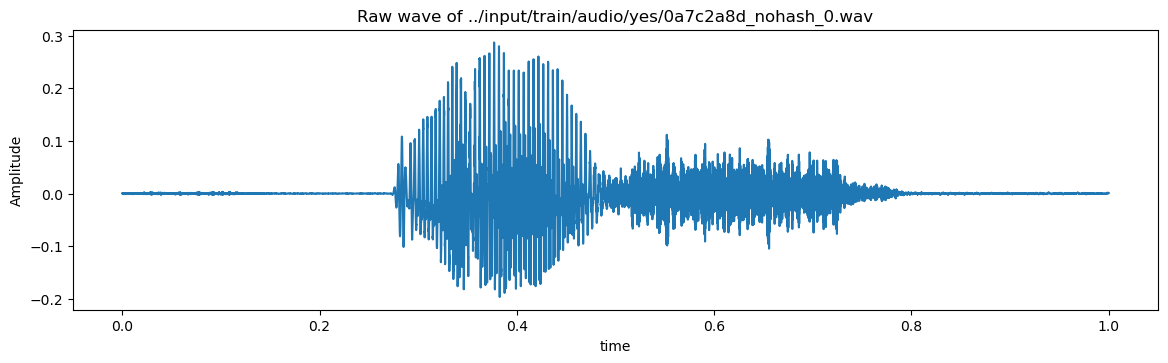

In [46]:
samples, sample_rate = librosa.load(train_audio_path+'yes/0a7c2a8d_nohash_0.wav', sr = 16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Onde brute de ' + '../input/train/audio/yes/0a7c2a8d_nohash_0.wav')
ax1.set_xlabel('Temps')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

In [162]:
import os

def count_files_in_subdirs(directory):
    total_files = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            total_files += 1
    return total_files



# Compter les fichiers dans les sous-dossiers
total_files = count_files_in_subdirs(train_audio_path)
print(f"Nombre total de fichiers dans les sous-dossiers : {total_files}")

Nombre total de fichiers dans les sous-dossiers : 64728


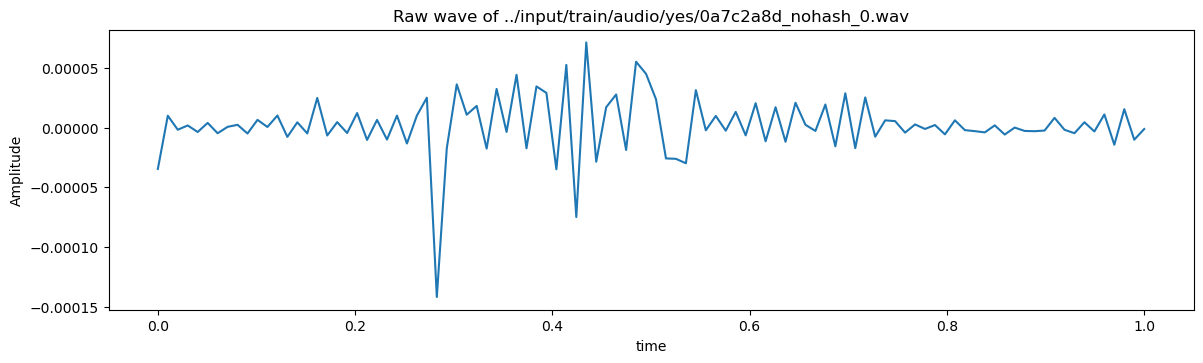

In [47]:
samples, sample_rate = librosa.load(train_audio_path+'yes/0a7c2a8d_nohash_0.wav', sr = 100)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + '../input/train/audio/yes/0a7c2a8d_nohash_0.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

**Taux d'échantillonnage**

Regardons maintenant le taux d'échantillonnage des signaux audio.

In [48]:
sample_rate=40000
samples, sample_rate = librosa.load(train_audio_path+'yes/0a7c2a8d_nohash_0.wav', sr = sample_rate)
ipd.Audio(samples, rate=sample_rate)

In [49]:
sample_rate=16000
samples, sample_rate = librosa.load(train_audio_path+'yes/0a7c2a8d_nohash_0.wav', sr = sample_rate)
ipd.Audio(samples, rate=sample_rate)

In [50]:
sample_rate=6000
samples, sample_rate = librosa.load(train_audio_path+'yes/0a7c2a8d_nohash_0.wav', sr = sample_rate)
ipd.Audio(samples, rate=sample_rate)

In [51]:
sample_rate=3000
samples, sample_rate = librosa.load(train_audio_path+'yes/0a7c2a8d_nohash_0.wav', sr = sample_rate)
ipd.Audio(samples, rate=sample_rate)

**Rééchantillonnage**

D'après ce qui précède, nous pouvons comprendre que le taux d'échantillonnage du signal est de 16000 Hz. Rééchantillonnons-le à 8000 Hz, car la plupart des fréquences liées à la parole se trouvent à 8000 Hz.

In [52]:
samples = librosa.resample(samples, orig_sr=sample_rate, target_sr=8000)
ipd.Audio(samples, rate=8000)

Maintenant, comprenons le nombre d'enregistrements pour chaque commande vocale :

In [53]:
import os
labels=os.listdir(train_audio_path)

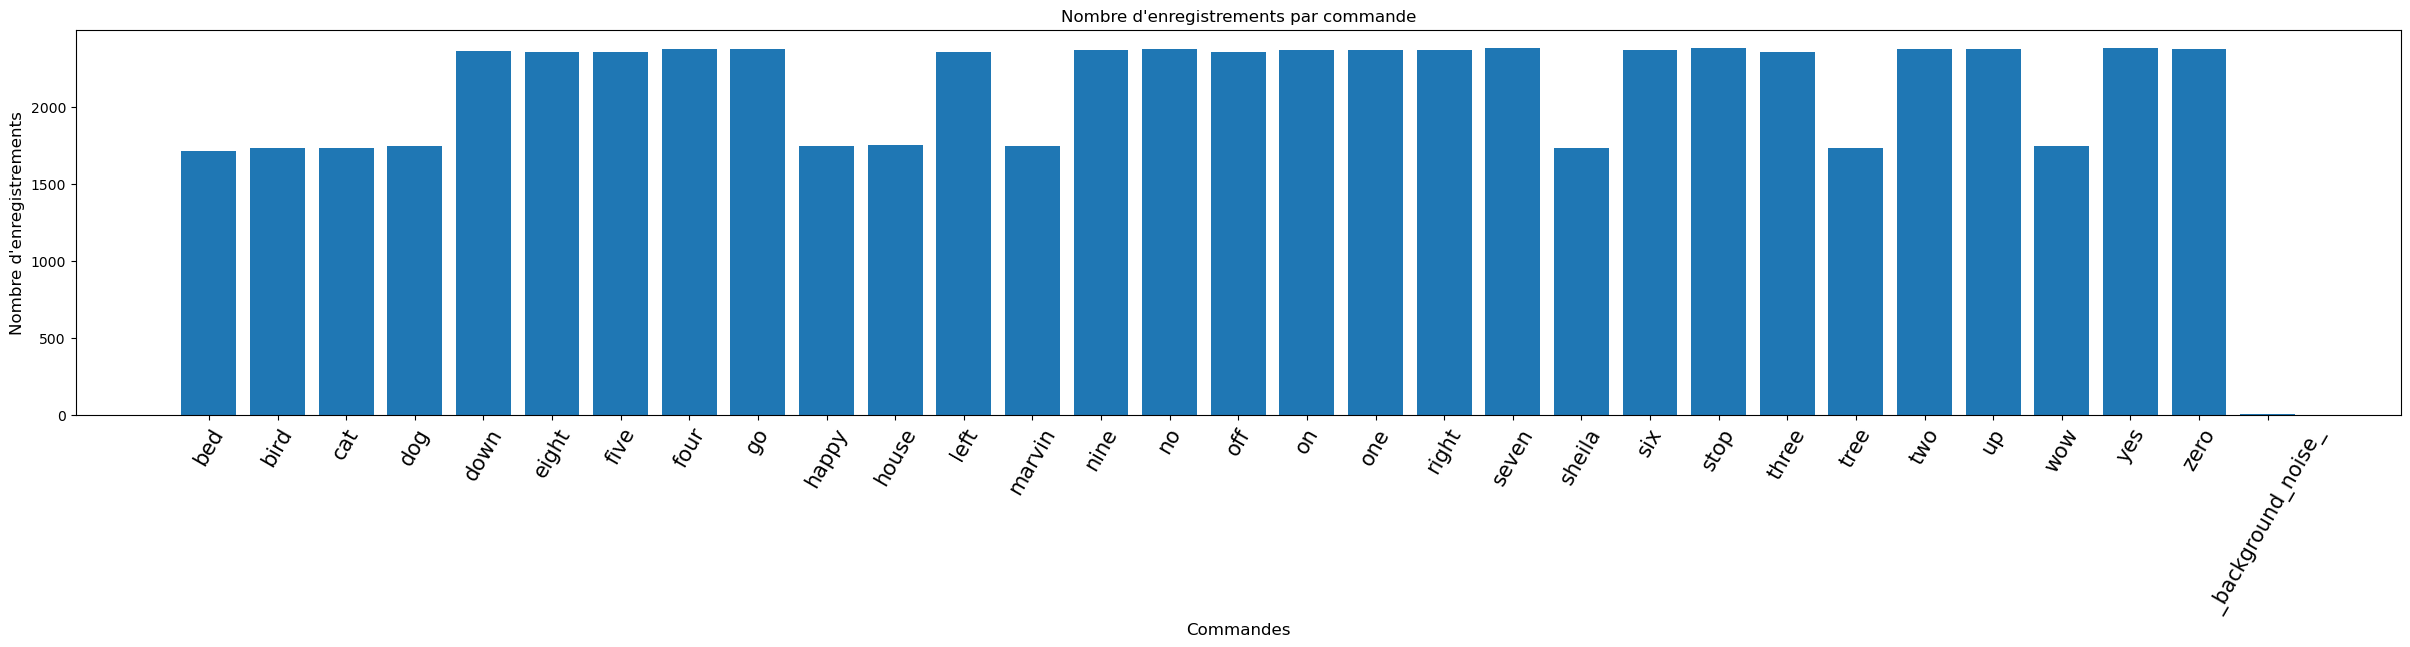

In [54]:
# Trouver le compte de chaque étiquette et tracer un graphique à barres
no_of_recordings = []  # Initialiser la liste pour stocker le nombre d'enregistrements par étiquette
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/' + label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))  # Ajouter le nombre d'enregistrements pour cette étiquette à la liste

# Tracer le graphique
plt.figure(figsize=(30, 5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commandes', fontsize=12)  # Titre de l'axe x
plt.ylabel("Nombre d'enregistrements", fontsize=12)  # Titre de l'axe y
plt.xticks(index, labels, fontsize=15, rotation=60)  # Afficher les étiquettes sur l'axe x
plt.title("Nombre d'enregistrements par commande")
plt.show()

In [55]:
# labels=["yes", "no","stop", "go"]
labels=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

**Durée des enregistrements**

Quelle est la prochaine étape ? Regardons la distribution de la durée des enregistrements :

(array([1.5000e+01, 3.0000e+01, 4.4000e+01, 1.3800e+02, 1.3600e+02,
        1.7900e+02, 3.6600e+02, 4.3400e+02, 5.9300e+02, 2.1747e+04]),
 array([0.418 , 0.4762, 0.5344, 0.5926, 0.6508, 0.709 , 0.7672, 0.8254,
        0.8836, 0.9418, 1.    ]),
 <BarContainer object of 10 artists>)

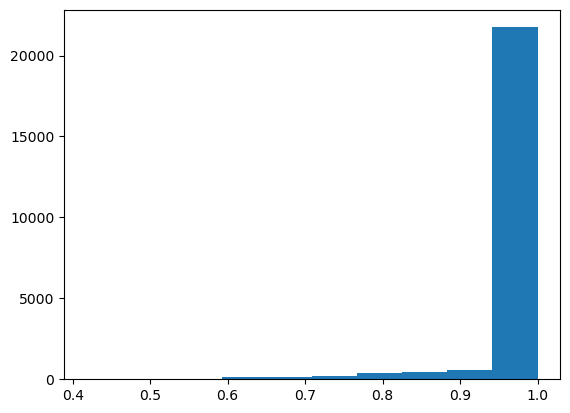

In [56]:
# Calculer la durée de chaque enregistrement
duration_of_recordings = []  # Initialiser la liste pour stocker les durées des enregistrements
for label in labels:
    # Parcourir les fichiers audio de chaque étiquette
    waves = [f for f in os.listdir(train_audio_path + '/' + label) if f.endswith('.wav')]
    for wav in waves:
        # Lire le fichier audio et calculer sa durée
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples) / sample_rate))  # Ajouter la durée à la liste

# Tracer l'histogramme des durées
plt.hist(np.array(duration_of_recordings))  # Tracer l'histogramme des durées des enregistrements

**Prétraitement des ondes audio**

Dans la partie précédente sur l'exploration des données, nous avons constaté que la durée de quelques enregistrements est inférieure à 1 seconde et que le taux d'échantillonnage est trop élevé. Alors, lisons les ondes audio et utilisons les étapes de prétraitement ci-dessous pour y remédier.

Voici les deux étapes que nous allons suivre :

* Rééchantillonnage
* Suppression des commandes plus courtes de moins de 1 seconde

Définissons ces étapes de prétraitement dans l'extrait de code ci-dessous :

In [167]:
# Charger tous les enregistrements audio et leurs étiquettes
all_wave = []  # Initialiser la liste pour stocker tous les enregistrements audio
all_label = []  # Initialiser la liste pour stocker toutes les étiquettes
for label in labels:
    print(label)  # Afficher l'étiquette en cours de traitement
    waves = [f for f in os.listdir(train_audio_path + '/' + label) if f.endswith('.wav')]
    for wav in waves:
        # Charger le fichier audio et le rééchantillonner à 8000 Hz
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr=16000)
        resampled_samples = librosa.resample(samples, orig_sr=sample_rate, target_sr=8000)
        # Vérifier si la durée de l'enregistrement est de 8000 échantillons
        if len(resampled_samples) == 8000:
            all_wave.append(resampled_samples)  # Ajouter l'enregistrement à la liste
            all_label.append(label)  # Ajouter l'étiquette à la liste
            

yes
no
up
down
left
right
on
off
stop
go


AttributeError: 'list' object has no attribute 'shape'

In [168]:
print(type(all_wave))
print(len(all_wave))

<class 'list'>
21312


In [177]:
print(len(all_wave))
print(all_wave[1].shape)
all_wave[1]


21312
(8000,)


array([0.00040267, 0.00062703, 0.00036664, ..., 0.00081659, 0.0004811 ,
       0.00071751], dtype=float32)

Convertir les étiquettes de sortie en encodage entier :

In [178]:
len(set(all_label))

10

In [179]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

In [180]:
classes

['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']

Convertissons maintenant les étiquettes encodées en entiers en un vecteur one-hot, puisqu'il s'agit d'un problème de classification multi-classes :

In [181]:
from keras.utils import to_categorical
y = to_categorical(y, num_classes=len(np.unique(y)))


In [182]:
len(y),y

(21312,
 array([[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        ...,
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.]], dtype=float32))

Redimensionnons le tableau 2D en un tableau 3D, car l'entrée pour la conv1d doit être un tableau 3D :

In [184]:
all_wave = np.array(all_wave).reshape(-1,8000,1)

In [84]:
all_wave.shape

(21312, 8000, 1)

**Diviser en ensemble d'entraînement et ensemble de validation**

Ensuite, nous entraînerons le modèle sur 80 % des données et validerons sur les 20 % restants :


In [87]:
X = all_wave.reshape(all_wave.shape[0], all_wave.shape[1], 1)
X.shape

(21312, 8000, 1)

In [185]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(
    X,
    y,
    stratify=y,
    test_size=0.2,
    random_state=777,
    shuffle=True
)
x_tr.shape,x_val.shape,y_tr.shape,y_val.shape

((17049, 8000, 1), (4263, 8000, 1), (17049, 10), (4263, 10))

**Architecture du Modèle pour ce Problème**

Nous allons construire le modèle de conversion de la parole en texte en utilisant Conv1D. Conv1D est un type de réseau neuronal convolutif qui effectue la convolution le long d'une seule dimension. 

**Construction du Modèle**

Implémentons le modèle en utilisant l'API fonctionnelle de Keras..

### Conv1D, Conv2D and Conv3D : https://xzz201920.medium.com/conv1d-conv2d-and-conv3d-8a59182c4d6

In [90]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

In [ ]:
# ?Conv1D

In [91]:
inputs = Input(shape=(8000, 1))

# Première couche Conv1D
conv = Conv1D(filters=8, kernel_size=13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

# Deuxième couche Conv1D 
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

# Troisième couche Conv1D
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

# Quatrième couche Conv1D
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

# Couche de Flattening
conv = Flatten()(conv)

# Première couche Dense
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

# Deuxième couche Dense
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8000, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 7988, 8)           112       
                                                                 
 max_pooling1d (MaxPooling1  (None, 2662, 8)           0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 2662, 8)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2652, 16)          1424      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 884, 16)           0         
 g1D)                                                       

Définissons la fonction de perte comme l'entropie croisée catégorique puisqu'il s'agit d'un problème de classification multi-classes :

In [92]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

L'arrêt précoce et les points de contrôle du modèle sont des rappels (callbacks) pour arrêter l'entraînement du réseau neuronal au bon moment et sauvegarder le meilleur modèle après chaque époque :

In [93]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

Entraînons le modèle avec une taille de lot de 32 et évaluons ses performances sur l'ensemble de validation :

In [94]:
history=model.fit(x_tr, y_tr ,epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

Epoch 1/100


533/533 [==============================] - 43s 73ms/step - loss: 2.0336 - accuracy: 0.2340 - val_loss: 1.6397 - val_accuracy: 0.4122
Epoch 2/100
533/533 [==============================] - 36s 68ms/step - loss: 1.4652 - accuracy: 0.4557 - val_loss: 1.2744 - val_accuracy: 0.5498
Epoch 3/100
533/533 [==============================] - 36s 68ms/step - loss: 1.1899 - accuracy: 0.5817 - val_loss: 0.9730 - val_accuracy: 0.6922
Epoch 4/100
533/533 [==============================] - 36s 68ms/step - loss: 0.9937 - accuracy: 0.6556 - val_loss: 0.7963 - val_accuracy: 0.7448
Epoch 5/100
533/533 [==============================] - 37s 69ms/step - loss: 0.8637 - accuracy: 0.7054 - val_loss: 0.7698 - val_accuracy: 0.7366
Epoch 6/100
533/533 [==============================] - 38s 70ms/step - loss: 0.7906 - accuracy: 0.7278 - val_loss: 0.7819 - val_accuracy: 0.7239
Epoch 7/100
533/533 [==============================] - 38s 72ms/step - loss: 0.7199 - accuracy: 0.7534 - val_loss: 0.6639 - val_

533/533 [==============================] - 36s 68ms/step - loss: 0.3505 - accuracy: 0.8822 - val_loss: 0.5216 - val_accuracy: 0.8377
Epoch 27/100
533/533 [==============================] - 37s 69ms/step - loss: 0.3457 - accuracy: 0.8824 - val_loss: 0.5387 - val_accuracy: 0.8318
Epoch 28/100
533/533 [==============================] - 36s 68ms/step - loss: 0.3478 - accuracy: 0.8815 - val_loss: 0.4798 - val_accuracy: 0.8475
Epoch 29/100
533/533 [==============================] - 36s 68ms/step - loss: 0.3298 - accuracy: 0.8866 - val_loss: 0.4884 - val_accuracy: 0.8478
Epoch 30/100
533/533 [==============================] - 38s 71ms/step - loss: 0.3276 - accuracy: 0.8917 - val_loss: 0.5108 - val_accuracy: 0.8363
Epoch 31/100
533/533 [==============================] - 38s 70ms/step - loss: 0.3108 - accuracy: 0.8920 - val_loss: 0.5324 - val_accuracy: 0.8311
Epoch 32/100
533/533 [==============================] - 43s 80ms/step - loss: 0.3143 - accuracy: 0.8929 - val_loss: 0.5406 - val_accuracy

**Graphique de Diagnostic**

Je vais encore une fois utiliser la visualisation pour comprendre la performance du modèle sur une période de temps :

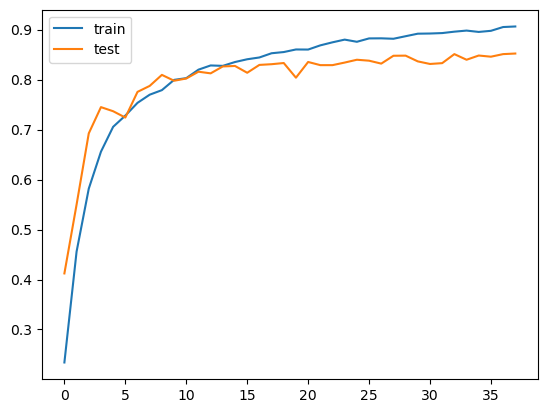

In [96]:
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

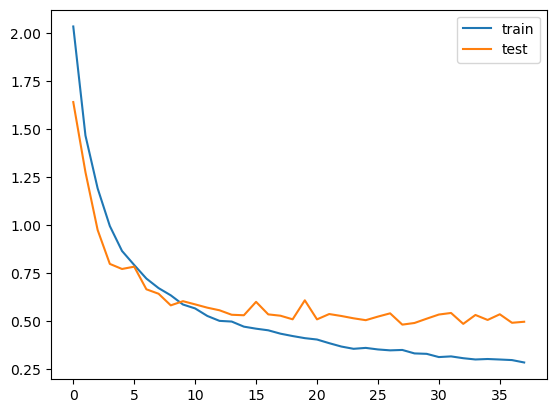

In [95]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

**Chargement du meilleur modèle**

In [97]:
from keras.models import load_model
model.save("../Desktop/projetDeeepCC/train/SpeechRecogModel.keras")
model.save("../Desktop/projetDeeepCC/train/SpeechRecogModel.h5")

Définissons la fonction qui prédit le texte pour l'audio donné :

In [98]:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

Il est temps de faire des prédictions ! Faisons des prédictions sur les données de validation :

In [191]:
import random
import numpy as np

index = random.randint(0, len(x_val) - 1)
samples = x_val[index].ravel()
true_label = np.argmax(y_val[index])
predicted_probs = model.predict(x_val[[index]])[0]
predicted_label = np.argmax(predicted_probs)
predicted_class = classes[predicted_label]
predicted_prob = predicted_probs[predicted_label]

print(f"Predicted audio class: {predicted_class}")
print(f"Predicted probability: {predicted_prob:.2f}")

ipd.Audio(samples, rate=8000)

1/1 [==============================] - 0s 48ms/step
Predicted audio class: no
Predicted probability: 1.00


In [192]:
print("Text:",predict(samples))

1/1 [==============================] - 0s 55ms/step
Text: no


**Le meilleur reste à venir ! Voici un script qui invite un utilisateur à enregistrer des commandes vocales. Enregistrez vos propres commandes vocales et testez-les sur le modèle :**

In [121]:
import sounddevice as sd
import soundfile as sf

In [152]:
samplerate = 16000  
duration = 1 # seconds
filename = '../Desktop/projetDeeepCC/test_au/audio.wav'
print("start")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,channels=1, blocking=True)
print("end")
sd.wait()
sf.write(filename, mydata, samplerate)

start
end


Lisons maintenant la commande vocale enregistrée et convertissons-la en texte :

In [153]:
samples, sample_rate = librosa.load(filename, sr=16000)
samples = librosa.resample(samples, orig_sr=sample_rate, target_sr=8000)
ipd.Audio(samples, rate=8000)           

In [154]:
# #converting voice commands to text
predict(samples)

1/1 [==============================] - 0s 26ms/step


'go'